In [0]:
%matplotlib inline
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
import pandas as pd
import nltk
import re
from scipy.spatial.distance import cdist
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, GRU, Embedding, Dropout
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

In [0]:
#/////////////////////////////////////
#// Use this on Google Colaboratory
#////////////////////////////////////

from google.colab import drive
drive.mount('/content/gdrive')
df = pd.read_csv("gdrive/My Drive/CZ4034 Info Retrieval/wilson_sentiments.csv", delimiter=",", header=0)



#////////////////////////////////
#// Use this on local machines
#///////////////////////////////

# df = pd.read_csv("./wilson_sentiments.csv", delimiter=",", header=0)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# Take only the csv entries with sentiments labelled
df_manual = df.head(1061)

In [0]:
df_manual = df_manual[["id", "sentiments", "quote"]]

In [0]:
df_manual

,id,sentiments,quote
0,0,0.0,"I'm selfish, impatient and a little insecure. ..."
1,1,1.0,Be yourself; everyone else is already taken.
2,2,0.0,Two things are infinite: the universe and huma...
3,3,0.0,"So many books, so little time."
4,4,0.0,"Be who you are and say what you feel, because ..."
...,...,...,...
1056,1056,1.0,"Remember that wherever your heart is, there yo..."
1057,1057,1.0,History will be kind to me for I intend to wri...
1058,1058,1.0,Respect other people's feelings. It might mean...
1059,1059,1.0,"Take responsibility of your own happiness, nev..."


In [0]:
from nltk.stem import WordNetLemmatizer
stemmer = WordNetLemmatizer()
nltk.download('wordnet')

processed_quotes = []

for sen in df_manual["quote"]:
    # Remove all the special characters
    document = re.sub(r'\W', ' ', str(sen))

    # remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
    
    # Remove single characters from the start
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 
    
    # Substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)
    
    # Removing prefixed 'b'
    document = re.sub(r'^b\s+', '', document)
    
    # Converting to Lowercase
    document = document.lower()
    
    # Lemmatization
    document = document.split()

    document = [stemmer.lemmatize(word) for word in document]
    document = ' '.join(document)
    
    processed_quotes.append(document)
    
df_manual["processed_quotes"] = processed_quotes
df_manual

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,id,sentiments,quote,processed_quotes
0,0,0.0,"I'm selfish, impatient and a little insecure. ...",i selfish impatient and little insecure make m...
1,1,1.0,Be yourself; everyone else is already taken.,be yourself everyone else is already taken
2,2,0.0,Two things are infinite: the universe and huma...,two thing are infinite the universe and human ...
3,3,0.0,"So many books, so little time.",so many book so little time
4,4,0.0,"Be who you are and say what you feel, because ...",be who you are and say what you feel because t...
...,...,...,...,...
1056,1056,1.0,"Remember that wherever your heart is, there yo...",remember that wherever your heart is there you...
1057,1057,1.0,History will be kind to me for I intend to wri...,history will be kind to me for intend to write it
1058,1058,1.0,Respect other people's feelings. It might mean...,respect other people feeling it might mean not...
1059,1059,1.0,"Take responsibility of your own happiness, nev...",take responsibility of your own happiness neve...


In [0]:
# print(df.iloc[:,3])  # take the processed quotes
# print(df.iloc[:,1])  # take only the sentiments

# x is the quotes, y is the sentiment values
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df_manual.iloc[:,3], df_manual.iloc[:,1], test_size=0.20, random_state=42)

# Check to see if x_train + x_test gives back 1061 entries
text = pd.concat([x_train,x_test])
print(text)

72     if you can explain it to six year old you don ...
898    true love is rare and it the only thing that g...
44     yesterday is history tomorrow is mystery today...
309             i would die for you but won live for you
784    it strange because sometimes read book and thi...
                             ...                        
581         think before you speak read before you think
55     i am enough of an artist to draw freely upon m...
120    it matter not what someone is born but what th...
388    nobody ha ever measured not even poet how much...
25     insanity is doing the same thing over and over...
Name: processed_quotes, Length: 1061, dtype: object


In [0]:
num_words = 10000
tokenizer = Tokenizer(num_words=num_words)
# print(tokenizer)
tokenizer.fit_on_texts(text)
x_train_tokens = tokenizer.texts_to_sequences(x_train)
x_test_tokens = tokenizer.texts_to_sequences(x_test)

In [0]:
num_tokens = [len(tokens) for tokens in x_train_tokens + x_test_tokens]
num_tokens = np.array(num_tokens)
print("Mean length is " + str(np.mean(num_tokens)))

Mean length is 22.611687087653156


In [0]:
#Chose to 2 S.D to cover ~95% of data
max_tokens = np.mean(num_tokens) + 2*np.std(num_tokens)
max_tokens = int(max_tokens)
print(max_tokens)

75


In [0]:
x_train_pad = pad_sequences(x_train_tokens, maxlen=max_tokens,
                            padding='pre', truncating='pre')
x_test_pad = pad_sequences(x_test_tokens, maxlen=max_tokens,
                           padding='pre', truncating='pre')

In [0]:
idx = tokenizer.word_index
inverse_map = dict(zip(idx.values(), idx.keys()))

In [0]:
def tokens_to_string(tokens):
    words = [inverse_map[token] for token in tokens if token != 0]
    text = " ".join(words)
    return text

In [0]:
model = Sequential()
embedding_size = 100

model.add(Embedding(input_dim=num_words,
                    output_dim=embedding_size,
                    input_length=max_tokens,
                    name='layer_embedding'))
model.add(GRU(units=16, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
model.add(GRU(units=16, return_sequences=True, dropout=0.5, recurrent_dropout=0.2))
model.add(GRU(units=8, return_sequences=True, dropout=0.5, recurrent_dropout=0.2))
model.add(GRU(units=4, dropout=0.5, recurrent_dropout=0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

Adam = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False)

model.compile(loss='binary_crossentropy',
              optimizer=Adam,
              metrics=['accuracy'])

In [0]:
history = model.fit(x_train_pad, 
                    y_train,
                    validation_split=0.05, 
                    epochs=20, 
                    batch_size=32)

Train on 805 samples, validate on 43 samples
Epoch 1/20
805/805 [==============================] - 21s 27ms/sample - loss: 0.6921 - accuracy: 0.5528 - val_loss: 0.6864 - val_accuracy: 0.6512
Epoch 2/20
805/805 [==============================] - 13s 16ms/sample - loss: 0.6890 - accuracy: 0.5565 - val_loss: 0.6740 - val_accuracy: 0.6512
Epoch 3/20
805/805 [==============================] - 13s 16ms/sample - loss: 0.6868 - accuracy: 0.5565 - val_loss: 0.6699 - val_accuracy: 0.6512
Epoch 4/20
805/805 [==============================] - 13s 16ms/sample - loss: 0.6845 - accuracy: 0.5553 - val_loss: 0.6663 - val_accuracy: 0.6512
Epoch 5/20
805/805 [==============================] - 13s 16ms/sample - loss: 0.6761 - accuracy: 0.5578 - val_loss: 0.6693 - val_accuracy: 0.6512
Epoch 6/20
805/805 [==============================] - 13s 16ms/sample - loss: 0.6270 - accuracy: 0.5950 - val_loss: 0.6875 - val_accuracy: 0.5814
Epoch 7/20
805/805 [==============================] - 13s 16ms/sample - loss: 0

In [0]:
# Evaluate the model
loss, accuracy = model.evaluate(x_test_pad, y_test, verbose=1)

213/213 [==============================] - 1s 3ms/sample - loss: 2.0060 - accuracy: 0.5822


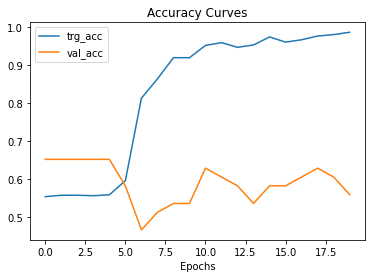

In [0]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Accuracy Curves")
plt.legend(["trg_acc", "val_acc"])
plt.xlabel("Epochs")
plt.show()

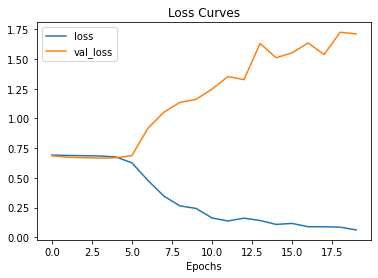

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Loss Curves")
plt.legend(["loss", "val_loss"])
plt.xlabel("Epochs")
plt.show()

In [0]:
predictions_gru = model.predict_classes(x_test_pad)

In [0]:
print(predictions_gru)

[[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]


In [0]:
predictions_gru.shape

(213, 1)

In [0]:
from sklearn.metrics import f1_score
gru_f1 = f1_score(y_test, predictions_gru, average='macro')
print("F1 Score for GRU is:", gru_f1)

F1 Score for GRU is: 0.5776540046786232


# Symbolic AI

In [0]:
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.metrics import accuracy_score
 
 
vader = SentimentIntensityAnalyzer()
def vader_polarity(text):
    """ Transform the output to a binary 0/1 result """
    score = vader.polarity_scores(text)
    return 1 if score['pos'] > score['neg'] else 0

predictions_vader = [vader_polarity(text) for text in x_test]

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [0]:
predictions_vader = np.array(predictions_vader).reshape(-1,1)

In [0]:
# print(predictions_vader)
vader_f1 = f1_score(y_test, predictions_vader, average='macro')

print("F1 Score for Symbolic AI method is:", vader_f1)

F1 Score for Symbolic AI method is: 0.6525745018515254


# Bert

In [0]:
!pip3 install ktrain

import ktrain
from ktrain import text

In [0]:
train_bert = pd.concat([x_train, y_train], axis=1, names=['preprocessed_quotes', 'sentiments'])

In [0]:
train_bert.shape

(848, 2)

In [0]:
(x_train_bert, y_train_bert, preproc) = text.texts_from_df(train_bert, 
                   text_column='processed_quotes', \
                   label_columns = 'sentiments', \
                   random_state=0, \
                    maxlen=500, \
                    preprocess_mode='bert') \

downloading pretrained BERT model (uncased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: en


preprocessing test...
language: en


In [0]:
y_train_bert

([array([[ 101, 1045, 2064, ...,    0,    0,    0],
         [ 101, 1045, 2442, ...,    0,    0,    0],
         [ 101, 2079, 2028, ...,    0,    0,    0],
         ...,
         [ 101, 2682, 2035, ...,    0,    0,    0],
         [ 101, 2022, 2785, ...,    0,    0,    0],
         [ 101, 2017, 2156, ...,    0,    0,    0]]),
  array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]])],
 array([[0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
 

In [0]:
test_bert = pd.concat([x_test, y_test], axis=1, names=['preprocessed_quotes', 'sentiments'])

In [0]:
test_bert

,processed_quotes,sentiments
31,it is our choice harry that show what we truly...,1.0
413,we fell in love despite our difference and onc...,1.0
535,the mind is it own place and in itself can mak...,0.0
743,no book is really worth reading at the age of ...,0.0
792,i wa never really insane except upon occasion ...,1.0
...,...,...
581,think before you speak read before you think,1.0
55,i am enough of an artist to draw freely upon m...,1.0
120,it matter not what someone is born but what th...,1.0
388,nobody ha ever measured not even poet how much...,0.0


In [0]:
(x_test_bert, y_test_bert, preproc_test) = text.texts_from_df(test_bert, 
                   text_column='processed_quotes', \
                   label_columns = ['sentiments'], \
                   random_state=0, \
                    maxlen=500, \
                    preprocess_mode='bert') \

preprocessing train...
language: en


preprocessing test...
language: en


In [0]:
type(x_train)

pandas.core.series.Series

In [0]:
(x_train_bert,  y_train_bert), (x_test_bert, y_test_bert), preproc = text.texts_from_array(x_train=x_train.tolist(), y_train=y_train.tolist(),
                                                                       x_test=x_test.tolist(), y_test=y_test.tolist(),
                                                                       class_names=[0., 1.],
                                                                       preprocess_mode='bert',
                                                                       maxlen=350)

task: text classification
preprocessing train...
language: en


preprocessing test...
language: en


In [0]:
model_bert = text.text_classifier('bert', train_data=(x_train_bert,y_train_bert), preproc=preproc)
learner = ktrain.get_learner(model_bert,train_data=(x_train_bert,y_train_bert), val_data=(x_test_bert, y_test_bert), batch_size=6)

Is Multi-Label? False
maxlen is 350
done.


In [0]:
bert_epoch = 1
for i in range (bert_epoch):
  learner.fit_onecycle(2e-5, 1)



begin training using onecycle policy with max lr of 2e-05...
Train on 848 samples, validate on 213 samples
848/848 [==============================] - 151s 178ms/sample - loss: 0.6827 - accuracy: 0.5943 - val_loss: 0.6058 - val_accuracy: 0.7512


In [0]:
predictor = ktrain.get_predictor(learner.model, preproc)

In [0]:
predictions_bert = predictor.predict(x_test.tolist())

In [0]:
predictions_bert = list(map(int, predictions_bert))
len(predictions_bert)

213

In [0]:
bert_f1 = f1_score(y_test, predictions_bert, average='macro')

print("F1 Score for BERT:", bert_f1)

F1 Score for BERT: 0.7511517689849003


# Ensemble RFC

In [0]:
df_ensemble = pd.DataFrame(predictions_gru, columns=["predictions_gru"])
df_ensemble['predictions_vader'] = predictions_vader
df_ensemble['predictions_bert'] = predictions_bert

In [0]:
df_ensemble

,predictions_gru,predictions_vader,predictions_bert
0,0,1,1
1,0,1,1
2,0,0,1
3,0,1,0
4,0,1,0
...,...,...,...
208,0,0,1
209,0,1,1
210,1,1,1
211,0,1,0


In [0]:
y_test = list(map(int, y_test))

In [0]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=10, random_state=0)
clf = clf.fit(df_ensemble, y_test)

In [0]:
clf.score(df_ensemble, y_test)

0.7511737089201878

# Text Processing for Unlabelled Quotes

In [0]:
df_auto = df.iloc[1061:,]
df_auto = df_auto[['id','sentiments','quote']]
df_auto

,id,sentiments,quote
1061,1061,NaN,"There are no facts, only interpretations."
1062,1062,NaN,He's a wallflower. You see things. You keep qu...
1063,1063,NaN,"Well, now"
1064,1064,NaN,How vain it is to sit down to write when you h...
1065,1065,NaN,What Is Love? I have met in the streets a very...
...,...,...,...
10567,10567,NaN,No one messes around with a nerds computer and...
10568,10568,NaN,"Come to think of it, she did not speak a word...."
10569,10569,NaN,"Yeah, I get it; you're a vampire, she said. Cr..."
10570,10570,NaN,Whew! You two are blowing hotter air than a to...


In [0]:
stemmer = WordNetLemmatizer()
nltk.download('wordnet')

processed_quotes = []

for sen in df_auto["quote"]:
    # Remove all the special characters
    document = re.sub(r'\W', ' ', str(sen))

    # remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
    
    # Remove single characters from the start
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 
    
    # Substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)
    
    # Removing prefixed 'b'
    document = re.sub(r'^b\s+', '', document)
    
    # Converting to Lowercase
    document = document.lower()
    
    # Lemmatization
    document = document.split()

    document = [stemmer.lemmatize(word) for word in document]
    document = ' '.join(document)
    
    processed_quotes.append(document)
    
df_auto["processed_quotes"] = processed_quotes
df_auto

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,id,sentiments,quote,processed_quotes
1061,1061,NaN,"There are no facts, only interpretations.",there are no fact only interpretation
1062,1062,NaN,He's a wallflower. You see things. You keep qu...,he a wallflower you see thing you keep quiet a...
1063,1063,NaN,"Well, now",well now
1064,1064,NaN,How vain it is to sit down to write when you h...,how vain it is to sit down to write when you h...
1065,1065,NaN,What Is Love? I have met in the streets a very...,what is love have met in the street very poor ...
...,...,...,...,...
10567,10567,NaN,No one messes around with a nerds computer and...,no one mess around with nerd computer and esca...
10568,10568,NaN,"Come to think of it, she did not speak a word....",come to think of it she did not speak word yet...
10569,10569,NaN,"Yeah, I get it; you're a vampire, she said. Cr...",yeah get it you re vampire she said creepy and...
10570,10570,NaN,Whew! You two are blowing hotter air than a to...,whew you two are blowing hotter air than torna...


In [0]:
auto_x = df_auto.iloc[:,3]
auto_y = df_auto.iloc[:,1]
auto_x

1061                 there are no fact only interpretation
1062     he a wallflower you see thing you keep quiet a...
1063                                              well now
1064     how vain it is to sit down to write when you h...
1065     what is love have met in the street very poor ...
                               ...                        
10567    no one mess around with nerd computer and esca...
10568    come to think of it she did not speak word yet...
10569    yeah get it you re vampire she said creepy and...
10570    whew you two are blowing hotter air than torna...
10571    don you see blaynie mitch put his arm around h...
Name: processed_quotes, Length: 9511, dtype: object

In [0]:
auto_y

1061    NaN
1062    NaN
1063    NaN
1064    NaN
1065    NaN
         ..
10567   NaN
10568   NaN
10569   NaN
10570   NaN
10571   NaN
Name: sentiments, Length: 9511, dtype: float64

In [0]:
### Need to use back the same initial configurations as the model

num_words = 10000
tokenizer = Tokenizer(num_words=num_words)
# print(tokenizer)

auto_x_pad = pad_sequences(auto_x_tokens, maxlen=77,
                            padding='pre', truncating='pre')
auto_x_pad

array([[   0,    0,    0, ...,  271,   52, 5040],
       [   0,    0,    0, ...,    4,    2,  244],
       [   0,    0,    0, ...,    0,  157,  112],
       ...,
       [   0,    0,    0, ...,  140,  719, 1122],
       [   0,    0,    0, ..., 5104,    9, 4835],
       [   0,    0,    0, ...,    8,   54,  247]], dtype=int32)

# Auto Prediction using GRU

In [0]:
auto_predictions_gru = model.predict_classes(auto_x_pad)
len(auto_predictions_gru)

9511

# Auto Prediction using Vader


In [0]:
auto_predictions_vader = [vader_polarity(text) for text in auto_x]
auto_predictions_vader = np.array(auto_predictions_vader).reshape(-1,1)
len(auto_predictions_vader)

9511

# Auto Prediction using BERT

In [0]:
auto_predictions_bert = predictor.predict(auto_x.tolist())
auto_predictions_bert = list(map(int, auto_predictions_bert))
len(auto_predictions_bert)

9511

# Ensemble Auto Prediction using RFC

In [0]:
auto_df_ensemble = pd.DataFrame(auto_predictions_gru, columns=['predictions_gru'])
auto_df_ensemble['predictions_vader'] = auto_predictions_vader
auto_df_ensemble['predictions_bert'] = auto_predictions_bert
auto_df_ensemble

,predictions_gru,predictions_vader,predictions_bert
0,1,0,0
1,0,0,1
2,1,1,1
3,0,0,0
4,0,1,0
...,...,...,...
9506,1,0,0
9507,1,1,0
9508,0,1,0
9509,0,0,0


In [0]:
auto_ensemble= clf.predict(auto_df_ensemble)
len(auto_ensemble)

9511

In [0]:
df_auto['sentiments'] = auto_ensemble
df_auto

,id,sentiments,quote,processed_quotes
1061,1061,0,"There are no facts, only interpretations.",there are no fact only interpretation
1062,1062,1,He's a wallflower. You see things. You keep qu...,he a wallflower you see thing you keep quiet a...
1063,1063,1,"Well, now",well now
1064,1064,0,How vain it is to sit down to write when you h...,how vain it is to sit down to write when you h...
1065,1065,0,What Is Love? I have met in the streets a very...,what is love have met in the street very poor ...
...,...,...,...,...
10567,10567,0,No one messes around with a nerds computer and...,no one mess around with nerd computer and esca...
10568,10568,0,"Come to think of it, she did not speak a word....",come to think of it she did not speak word yet...
10569,10569,0,"Yeah, I get it; you're a vampire, she said. Cr...",yeah get it you re vampire she said creepy and...
10570,10570,0,Whew! You two are blowing hotter air than a to...,whew you two are blowing hotter air than torna...


In [0]:
df_auto.to_csv(r'./autoclassification_results.csv',index=False)